In [64]:
pip install matplotlib textblob scikit-learn



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load the data from the csv files
training_data = pd.read_csv('/Users/jazucena/Downloads/EECS448/wine_somMLier-main/cleaned_wine_training_data.csv')

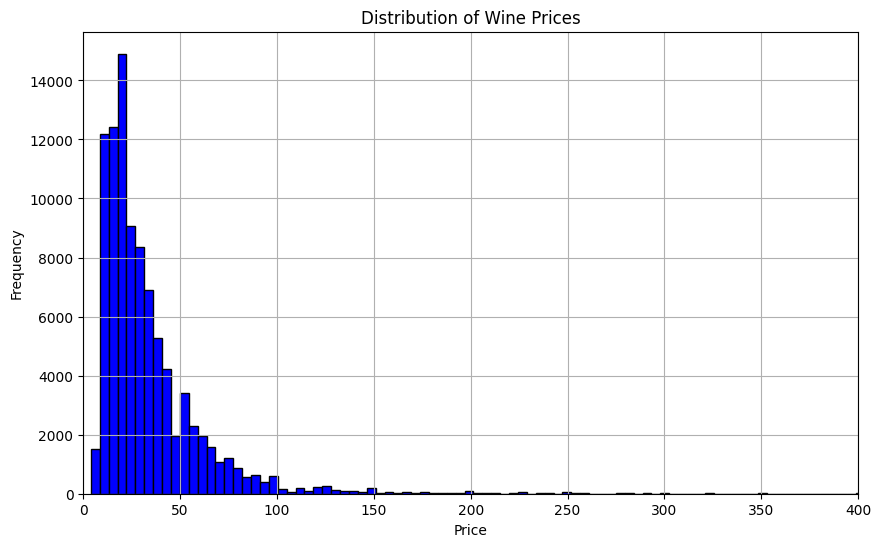

In [87]:
#Original Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(training_data['price'], bins=500, color='blue', edgecolor='black')
plt.title('Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0, 400)
plt.show()
#axis

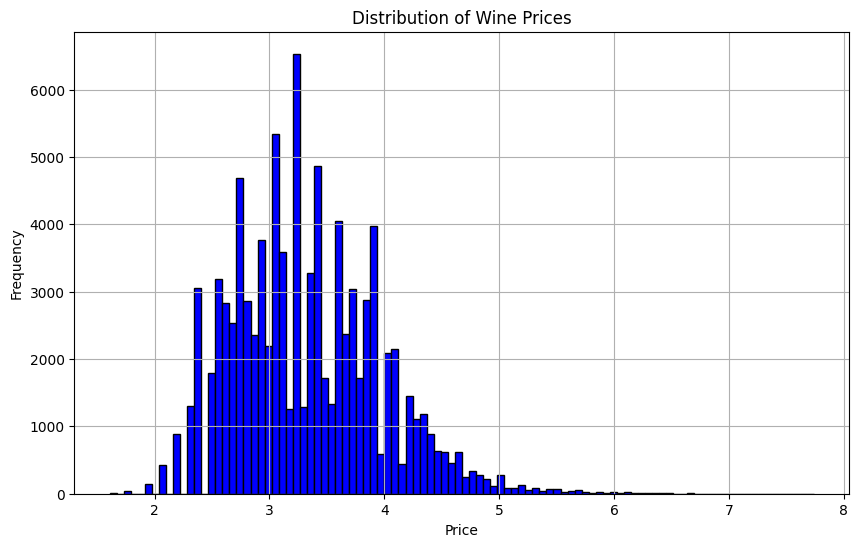

In [9]:
#Log Distribution 
log_prices = np.log(training_data['price'] + 1) #+1 prevents log(0)
plt.figure(figsize=(10, 6))
plt.hist(log_prices, bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Transformed data: [2.09269276 2.23843814 1.67992629 ... 1.84437062 2.2821245  2.00203235]
Lambda value: -0.2899198074563182


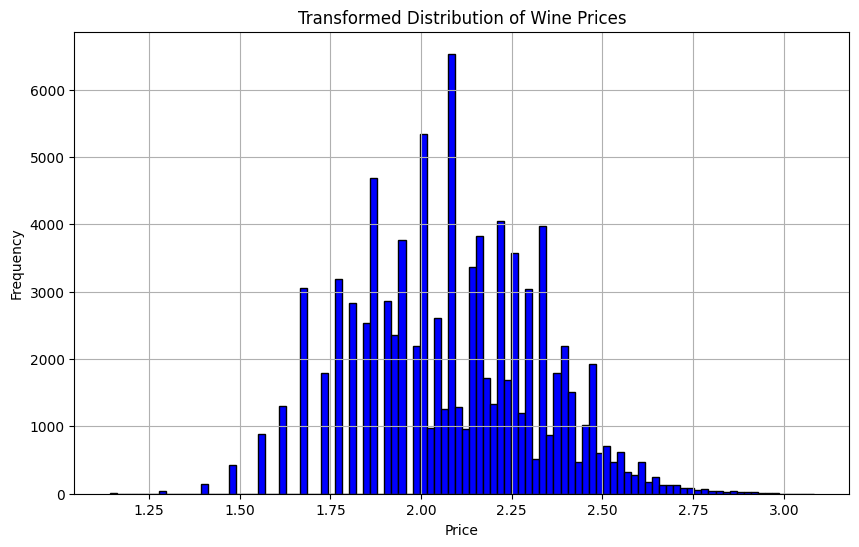

In [88]:
#Box Cox Transformation
from scipy.stats import boxcox

prices = np.array(training_data['price'])
to_remove = np.where(np.isnan(prices))[0]

cleaned_y = np.delete(prices, to_remove)
cleaned_X = training_data.drop(to_remove)
assert len(cleaned_X) == len(cleaned_y)

transformed_prices, best_lambda = boxcox(cleaned_y)

print("Transformed data:", transformed_prices)
print("Lambda value:", best_lambda)

#Box Cox Distribution
plt.figure(figsize=(10, 6))
plt.hist(transformed_prices, bins=100, color='blue', edgecolor='black')
plt.title('Transformed Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [68]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score

# helper function for measuring accuracy within threshold
def accuracy(y_true, y_pred, threshold):
    correct = 0
    total = len(y_true)
    for true, pred in zip(y_true, y_pred):
        if abs(true - pred) <= threshold:
            correct += 1
    return correct / total

# load validation data
data = pd.read_csv("cleaned_wine_validation_data.csv")

# if data is has price column as empty, exclude from data
data = data[data['price'].notnull()]

In [69]:
print("\n---------Linear Regression with Just Description---------")

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(data['description'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
train_r2 = r2_score(y_train, train_preds)  # 0.2603
test_r2 = r2_score(y_test, test_preds)  # 0.1681

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2 Score:", train_r2)
print("Test R2 Score:", test_r2)


---------Linear Regression with Just Description---------
Train RMSE: 31.319728401623024
Test RMSE: 35.526349174650285
Train R2 Score: 0.26033693714484607
Test R2 Score: 0.1680509349930147


In [80]:
print("\n---------BOX COX Linear Regression with Just Description---------")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
Xb = tfidf_vectorizer.fit_transform(cleaned_X['description'])

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, transformed_prices, test_size=0.2, random_state=42)

box_model = LinearRegression()
box_model.fit(Xb_train, yb_train)
box_train_preds = box_model.predict(Xb_train)
box_test_preds = box_model.predict(Xb_test)

box_train_rmse = root_mean_squared_error(yb_train, box_train_preds)
box_test_rmse = root_mean_squared_error(yb_test, box_test_preds)
box_train_r2 = r2_score(yb_train, box_train_preds) 
box_test_r2 = r2_score(yb_test, box_test_preds) 

print("Train RMSE:", box_train_rmse)
print("Test RMSE:", box_test_rmse)
print("Train R2 Score:", box_train_r2)
print("Test R2 Score:", box_test_r2)


---------BOX COX Linear Regression with Just Description---------
Train RMSE: 0.18787329308195885
Test RMSE: 0.1891592113026278
Train R2 Score: 0.4257801516524583
Test R2 Score: 0.41508158762509084
[2.25890316 2.1715029  1.89886198 ... 2.22455557 1.95564274 2.13743054]
[1.89343003 1.96338167 2.20694509 ... 2.01175427 2.03517669 2.05328799]
Accuracy within $ 5 : 1.0
Accuracy within  10.0 %: 1.0


In [76]:
#Un-tranforming
def undo(y_transformed, lamb):
    # return np.exp(np.log(lamb * y_transformed + 1) / lamb)
    return (y_transformed * lamb + 1) ** (1 / lamb)


y_og_pred = undo(box_test_preds, best_lambda)
y_og_actual = undo(yb_test, best_lambda)
assert(len(box_test_preds)==len(yb_test)==len(y_og_pred)==len(y_og_actual))
print(y_og_pred)
print(y_og_actual)

box_test_rmse = root_mean_squared_error(y_og_actual, y_og_pred)
box_test_r2 = r2_score(y_og_actual, y_og_pred) 
print("---BOX COX rescaled---")
print("Test RMSE:", box_test_rmse)
print("Test R2 Score:", box_test_r2)


[15.5824156  18.26198222 33.86389205 ... 20.47043254 21.66388646
 22.64887134]
[24. 68. 24. ... 30. 32. 35.]
---BOX COX rescaled---
Test RMSE: 31.23100366354667
Test R2 Score: 0.17898044005581415


In [77]:
#Price Anomaly Detection
mean_price = training_data['price'].mean()
sd_price = training_data['price'].std()
hurdle_rate = 3
hurdle = mean_price + hurdle_rate*sd_price
assert(hurdle==mean_price+3*sd_price)
num_anomalies = sum(training_data['price']>mean_price+3*sd_price)

littleX = training_data
littleX = littleX.drop(littleX[littleX['price']>hurdle].index)

print("Mean Price: ", mean_price)
print("Standard Deviation: ", sd_price)
print("Hurdle: ", hurdle)
print("Number of wines greater than ", hurdle_rate, " standard deviations from the mean: ", num_anomalies)

Mean Price:  34.564780128559875
Standard Deviation:  37.45773458078617
Hurdle:  146.9379838709184
Number of wines greater than  3  standard deviations from the mean:  1164


In [74]:
print("\n---------SUBSET Linear Regression with Just Description---------")
littleX = littleX.drop(to_remove)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(littleX['description'])
y = littleX['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
train_r2 = r2_score(y_train, train_preds)  # 0.2603
test_r2 = r2_score(y_test, test_preds)  # 0.1681

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2 Score:", train_r2)
print("Test R2 Score:", test_r2)



---------SUBSET Linear Regression with Just Description---------
Train RMSE: 17.83180749869777
Test RMSE: 17.930134896440567
Train R2 Score: 0.34708116305885117
Test R2 Score: 0.3281930900722887
